In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)

    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [4]:
data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x])for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [5]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

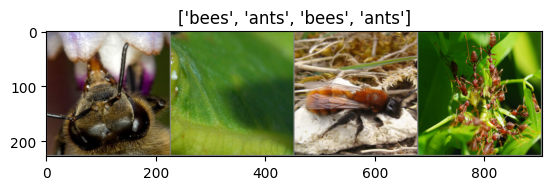

In [6]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

#### Finetuning the convet

Fine-tuning = Tải mô hình pretrained + chỉnh sửa lớp cuối cùng + train lại toàn bộ mô hình hoặc một phần trên dữ liệu mới.

In [ ]:
#Tải mô hình ResNet-18 đã được huấn luyện sẵn trên ImageNet. Mạng này có sẵn trọng số rất tốt để trích xuất đặc trưng từ ảnh.

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)# Thay thế lớp fully-connected cuối cùng (fc) từ 1000 output → 2 output (phân loại 2 lớp: ong và kiến).
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)#Dùng SGD để train lại toàn bộ model (bao gồm cả các tầng sớm đã pretrained).

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #Sau mỗi 7 epoch, giảm learning rate xuống 10 lần → giúp ổn định việc học ở giai đoạn sau.

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs= 25)

d:\Workspace\python\Pytorch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Workspace\python\Pytorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7308 Acc: 0.5287
val Loss: 0.5271 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5687 Acc: 0.7008
val Loss: 0.3607 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4659 Acc: 0.7869
val Loss: 0.2949 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4242 Acc: 0.7992
val Loss: 0.2557 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4510 Acc: 0.7910
val Loss: 0.2563 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4225 Acc: 0.8197
val Loss: 0.2180 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3915 Acc: 0.8402
val Loss: 0.2131 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3692 Acc: 0.8361
val Loss: 0.2026 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3394 Acc: 0.8811
val Loss: 0.1954 Acc: 0.9739

Epoch 9/24
----------
train Loss: 0.3348 Acc: 0.8648
val Loss: 0.2017 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3902 Acc: 0.8115
val Loss: 0.2192 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3557 Acc: 0.8484
val Loss: 0.1985 Acc: 0.9412

Ep

#### ConvNet as fixed feature extractor 

Feature Extraction = dùng lại các tầng sớm (feature extractor) của mô hình pretrained, đóng băng chúng lại, chỉ huấn luyện phần classifier (fc layer).

Ý tưởng: Các tầng đầu của CNN học được những đặc trưng hình ảnh phổ quát như cạnh, góc, màu...

Mình tận dụng các đặc trưng này thay vì học lại từ đầu (rất tốn dữ liệu và thời gian).



In [ ]:
model_conv = torchvision.models.resnet18(pretrained = True)

#Không cập nhật gradient cho các tầng convolution.

#Các tầng này giữ nguyên chức năng trích xuất đặc trưng.

for param in model_conv.parameters():
    param.requires_grad = False

#Thay thế lớp fully-connected cuối cùng
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)#Thay fc từ 1000 lớp (ImageNet) thành 2 lớp (binary classification).
#Chỉ lớp này được huấn luyện.

model_conv = model_conv.to(device)

critetion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
#model_conv.fc.parameters() → chỉ tối ưu trọng số của fc layer, không đụng vào phần còn lại.
#Momentum giúp tăng tốc hội tụ.


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

d:\Workspace\python\Pytorch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Workspace\python\Pytorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.8404 Acc: 0.5451
val Loss: 0.3937 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.4021 Acc: 0.8074
val Loss: 0.1830 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5699 Acc: 0.7664
val Loss: 0.2287 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4986 Acc: 0.7869
val Loss: 0.1866 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4539 Acc: 0.8156
val Loss: 0.1965 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4774 Acc: 0.7992
val Loss: 0.2251 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5470 Acc: 0.7746
val Loss: 0.2197 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3796 Acc: 0.8443
val Loss: 0.1718 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3806 Acc: 0.8361
val Loss: 0.1811 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3450 Acc: 0.8730
val Loss: 0.2071 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3984 Acc: 0.8238
val Loss: 0.1809 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3904 Acc: 0.8443
val Loss: 0.1850 Acc: 0.9542

Ep